### FORECASTING ATMOSPHERIC CO2
### SADID BIN HASAN

In [ ]:
# Loading packages
import scipy.stats as sts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
from IPython.display import display

### Collecting data from website

In [ ]:
# COLLECTION
data = pd.read_csv(
    "http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv", 
    names=["Date", "ppm"])

# CHANGING TO DATETIME USING PANDAS
data["Date"] = pd.to_datetime(data["Date"])

#PRINTING THE INITIAL FRAME
print("We have a total of {:d} datapoints".format(len(data)))
display(data.head())

We have a total of 3210 datapoints


,Date,ppm
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


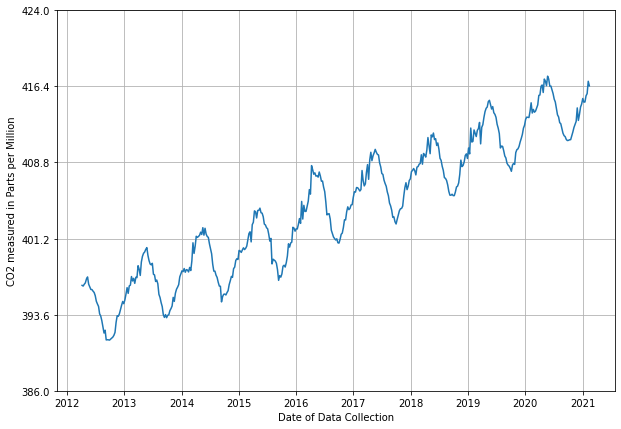

In [ ]:
# Looking at the recent data points

plt.figure(figsize=(10,7))
plt.plot(data.loc[2750:, ["Date"]], data.loc[2750:, ["ppm"]])
plt.grid()
plt.xlabel("Date of Data Collection")
plt.ylabel('CO2 measured in Parts per Million')
plt.yticks(np.linspace(386, 424, 6))
plt.show()

In [ ]:
# SINCE THE START OF DATA, WE CHANGE THE CALCULATION TO YEARS
data["Years"] = ((pd.to_datetime(data.Date) - pd.to_datetime(data.Date[0])).dt.days) / 365.25
# dividing by 365.25 to get the annual data

# CREATING THE PROGRESSION OF THE TIME SINCE THE START AS FRACTIONS
data["Time"] = data["Years"] / max(data["Years"])

display(data.tail(n=3))
# DISPLAYING THE YEARS IN THE END

,Date,ppm,Years,Time
3207,2021-01-30,415.68,62.841889,0.999390
3208,2021-02-06,416.91,62.861054,0.999695
3209,2021-02-13,416.45,62.880219,1.000000


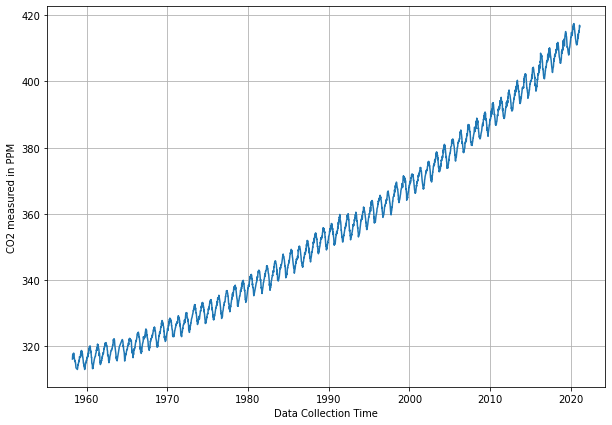

In [ ]:
# TAKING THE ENTIRE DATA AND SHOWING THE PLOT
plt.figure(figsize=(10,7))
plt.plot(data.Date, data.ppm)
plt.grid()
plt.xlabel("Data Collection Time")
plt.ylabel('CO2 measured in PPM')
plt.show()

In [ ]:
# storing our progression of collection time
time_wise_data_pyS = {
    "quantity" : data.ppm.values,
    "Total_dps" : len(data), 
    "year_clock" : data.Time.values
}
# storing our year wise data
year_wise_data_pyS = {
    "quantity" : data.ppm.values,
    "Total_dps" : len(data), 
    "year_clock" : data.Years.values    
}

## PYSTAN AT THE TREND OF THE DATA

In [ ]:
initial_exponentiality = """
data {
    int<lower=0> Total_dps;               // total data points
    real<lower=0> year_clock[Total_dps];       // time since starting of count
    real<lower=0> quantity[Total_dps];      // quantity of CO2
}

parameters {
    real<lower=0> prior_alpha;                
    real<lower=0> prior_beta;
    real<lower=0> irregularity_sts;
}

model {

    prior_alpha ~ normal(298, 18);
    prior_beta ~ normal(1, 1);
    irregularity_sts ~ normal(4.8, 1.8);
    for (q in 1:Total_dps) {
        quantity[q] ~ normal(prior_alpha*exp(prior_beta*year_clock[q]), irregularity_sts); 
    }
}
"""


initial_linearity = """
data {
    int<lower=0> Total_dps;               // total data points
    real<lower=0> year_clock[Total_dps];       // time since starting of count
    real<lower=0> quantity[Total_dps];      // quantity of CO2
}

parameters {
    real<lower=0> prior_alpha;                
    real<lower=0> prior_beta;
    real<lower=0> irregularity_sts;
}

model {
    prior_alpha ~ normal(298, 18);
    prior_beta ~ normal(1, 2);
    irregularity_sts ~ normal(9.8, 1.8);
    
    for (q in 1:Total_dps) {
        quantity[q] ~ normal(prior_alpha + prior_beta*year_clock[q], irregularity_sts); 
    }
}
"""


initial_quadracity = """
data {
    int<lower=0> Total_dps;                  // total data points
    real<lower=0> year_clock[Total_dps];     // time since starting of count
    real<lower=0> quantity[Total_dps];       // quantity of CO2
}

parameters {
    real<lower=0> prior_alpha;                
    real prior_beta;
    real prior_c;
    real<lower=0> irregularity_sts;
}

model {
    prior_alpha ~ normal(299, 18);
    prior_beta ~ normal(0, 10);
    prior_c ~ normal(0, 1.9);
    irregularity_sts ~ normal(9.8, 1.8);
    
    for (q in 1:Total_dps) {
        quantity[q] ~ normal(prior_alpha + prior_beta*year_clock[q] + prior_c*(year_clock[q]^2), irregularity_sts); 
    }
}

"""

#compiling the results for the pystan model
rep_linear = pystan.StanModel(model_code = initial_linearity)
rep_quadratic = pystan.StanModel(model_code = initial_quadracity)
rep_exponential = pystan.StanModel(model_code = initial_exponentiality)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0cee63844bd835ce7b518a0f9289ae51 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9f4acb7fd8933c31af1d225f8bdb7da1 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b153c7ee8c6a3f9a52168dd7c09691b NOW.


# ## LINEAR OUTCOME

In [ ]:
outcome_linear = rep_linear.sampling(data=year_wise_data_pyS)
print(outcome_linear)

Inference for Stan model: anon_model_0cee63844bd835ce7b518a0f9289ae51.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prior_alpha      305.64  3.2e-3   0.16 305.31 305.53 305.64 305.74 305.95   2501    1.0
prior_beta         1.59  9.6e-5 4.4e-3   1.58   1.59   1.59    1.6    1.6   2118    1.0
irregularity_sts   4.47  1.5e-3   0.06   4.37   4.44   4.48   4.51   4.59   1469    1.0
lp__              -6407    0.04   1.23  -6410  -6408  -6407  -6406  -6406   1243    1.0

Samples were drawn using NUTS at Fri Apr 23 02:49:18 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# ## QUADRATIC OUTCOME

In [ ]:
outcome_quadratic = rep_quadratic.sampling(data=year_wise_data_pyS)
print(outcome_quadratic)

Inference for Stan model: anon_model_9f4acb7fd8933c31af1d225f8bdb7da1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prior_alpha       314.7  5.0e-3   0.12 314.46 314.62  314.7 314.79 314.95    629    1.0
prior_beta         0.75  3.8e-4 9.0e-3   0.73   0.75   0.75   0.76   0.77    543    1.0
prior_c            0.01  5.6e-6 1.4e-4   0.01   0.01   0.01   0.01   0.01    590    1.0
irregularity_sts   2.25  4.9e-4   0.03   2.19   2.23   2.25   2.27    2.3   3393    1.0
lp__              -4206    0.04   1.44  -4209  -4206  -4205  -4205  -4204   1035    1.0

Samples were drawn using NUTS at Fri Apr 23 02:51:06 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# ## EXPONENTIALS OUTCOME

In [ ]:
outcome_exponential = rep_exponential.sampling(data=time_wise_data_pyS)
print(outcome_exponential)


Inference for Stan model: anon_model_0b153c7ee8c6a3f9a52168dd7c09691b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prior_alpha      307.66  2.8e-3   0.12 307.43 307.58 307.66 307.74  307.9   1821   1.01
prior_beta         0.28  1.5e-5 6.2e-4   0.28   0.28   0.28   0.28   0.28   1677   1.01
irregularity_sts    3.6  1.4e-3   0.04   3.52   3.57    3.6   3.63   3.69    984   1.01
lp__              -5712    0.03   1.18  -5715  -5713  -5712  -5712  -5711   1357    1.0

Samples were drawn using NUTS at Fri Apr 23 02:48:23 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# ## RMSE CALCULATION

In [ ]:
#CALCULATING THE RMSE TO FIND THE MODEL WHICH IS THE BEST FIT 
dps_linear = outcome_linear.extract() 
dps_quadratic = outcome_quadratic.extract()
dps_exponential = outcome_exponential.extract()

# calculating respective values from extracted sample data points
calculate_linear = dps_linear['prior_alpha'].mean() + dps_linear['prior_beta'].mean()*data.Years.values
calculate_quadratic = dps_quadratic['prior_alpha'].mean() + dps_quadratic['prior_beta'].mean()*data.Years.values + dps_quadratic['prior_c'].mean()*data.Years.values**2
calculate_exponential = dps_exponential['prior_alpha'].mean()*np.exp(dps_exponential['prior_beta'].mean()*data.Time.values)

#calculating the residuals from each model

R_linear = data.ppm - calculate_linear
R_quadratic = data.ppm - calculate_quadratic
R_exponential = data.ppm - calculate_exponential

# calculating the root mean square error and comparing
linear_compare = np.sqrt(np.mean(R_linear**2))
quadratic_compare = np.sqrt(np.mean(R_quadratic**2))
exponential_compare = np.sqrt(np.mean(R_exponential**2))

print(f'Linear RMSE {linear_compare}')
print(f'Quadratic RMSE {quadratic_compare}')
print(f'Exponential RMSE {exponential_compare}')


Linear RMSE 4.466932212042579
Quadratic RMSE 2.245389982685228
Exponential RMSE 3.5997100740753676


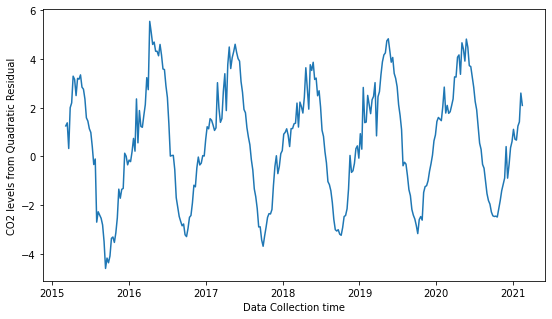

In [ ]:
# using quadratic model to show the the CO2 increase
# without using trends
data["quantity"] = R_quadratic
plt.figure(figsize=(9,5))
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["quantity"]])
plt.xlabel("Data Collection time")
plt.ylabel('CO2 levels from Quadratic Residual')
plt.show()

### Modeling: Seasonality

In [ ]:
year_wise_data_pyS = {
    "Total_dps" : len(data),
    "year_counter" : data.Years.values,
    "quantity" : data.quantity.values,
    "time_series" : 2*np.pi
}

In [ ]:
#IN SHA ALLAH

In [ ]:
# trying out four models to see which model fits atmospheric data the best
# sin, cosine, sin 2x, sin -2x models used to determine the fit of our data
# use of trigonometric relationships and graphs to fit our data

trig_sin = """
data {
    int<lower=0> Total_dps;                   // total data points
    real<lower=0> year_counter[Total_dps];    // time since beginning of count
    real quantity[Total_dps];                 // CO2 quantity for all datapoints
    real<lower=0> time_series;
}

parameters {
    real<lower=0> prior_alpha;
    unit_vector[2] phase_helper1;
    real<lower=0> irregularity_sts;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
    prior_alpha ~ normal(3.8, 1.8);
    irregularity_sts ~ inv_gamma(2.8, 1.9);

    for (q in 1:Total_dps) {
        quantity[q] ~ normal(prior_alpha*sin(time_series*year_counter[q] + phase1), irregularity_sts); 
    }
}

"""

trig_cosine = """
data {
    int<lower=0> Total_dps;                   // total data points
    real<lower=0> year_counter[Total_dps];    // time since beginning of count
    real quantity[Total_dps];                 // CO2 quantity for all datapoints
    real<lower=0> time_series;
}

parameters {
    real<lower=0> prior_alpha;
    unit_vector[2] phase_helper1;
    real<lower=0> irregularity_sts;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
    prior_alpha ~ normal(3.8, 1.8);
    irregularity_sts ~ inv_gamma(2.8, 1.9);

    for (q in 1:Total_dps) {
        quantity[q] ~ normal(prior_alpha*cos(time_series*year_counter[q] + phase1), irregularity_sts); 
    }
}

"""

trig_sin_plus_2x = """
data {
    int<lower=0> Total_dps;                   // total data points
    real<lower=0> year_counter[Total_dps];    // time since beginning of count
    real quantity[Total_dps];                 // CO2 quantity for all datapoints
    real<lower=0> time_series;
}

parameters {
    real<lower=0> prior_alpha;                
    real<lower=0> prior_beta;
    unit_vector[2] phase_helper1;
    real<lower=0> irregularity_sts;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
    prior_alpha ~ normal(0, 3.8);
    prior_beta ~ normal(0, 3.8);
    irregularity_sts ~ inv_gamma(2.8, 1.9);

    for (q in 1:Total_dps) {
        quantity[q] ~ normal(prior_alpha*sin(time_series*year_counter[q] + phase1) + prior_beta*sin(time_series*2*year_counter[q] + phase1), irregularity_sts); 
    }
}

"""

trig_sin_minus_2x = """
data {
    int<lower=0> Total_dps;                   // total data points
    real<lower=0> year_counter[Total_dps];    // time since beginning of count
    real quantity[Total_dps];                 // CO2 quantity for all datapoints
    real<lower=0> time_series;
}

parameters {
    real<lower=0> prior_alpha;                
    real<upper=0> prior_beta;
    unit_vector[2] phase_helper1;
    real<lower=0> irregularity_sts;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {

    prior_alpha ~ normal(0, 3.8);
    prior_beta ~ normal(0, 3.8);
    irregularity_sts ~ inv_gamma(2.8, 1.9);

    for (q in 1:Total_dps) {
        quantity[q] ~ normal(prior_alpha*sin(time_series*year_counter[q] + phase1) + prior_beta*sin(time_series*2*year_counter[q] + phase1), irregularity_sts); 
    }
}

"""

represent_sin = pystan.StanModel(model_code=trig_sin)
represent_cos = pystan.StanModel(model_code=trig_cosine)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_48ffe3f3df651cbf3b19fabfeeef487b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55ce0be75ed3a6401d035c8b2c0047dc NOW.


In [ ]:
trig_sin_outcome = represent_sin.sampling(data=year_wise_data_pyS) 
print(trig_sin_outcome)

Inference for Stan model: anon_model_48ffe3f3df651cbf3b19fabfeeef487b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prior_alpha        2.86  7.4e-4   0.02   2.81   2.84   2.86   2.87   2.91   1101    1.0
phase_helper1[1]   0.92  5.9e-5 3.4e-3   0.91   0.91   0.92   0.92   0.92   3453    1.0
phase_helper1[2]    0.4  1.3e-4 7.9e-3   0.38   0.39    0.4   0.41   0.42   3473    1.0
irregularity_sts   0.98  3.4e-4   0.01   0.96   0.97   0.98   0.99   1.01   1228    1.0
phase1             1.16  1.5e-4 8.6e-3   1.14   1.15   1.16   1.17   1.18   3470    1.0
lp__              -1551    0.08   1.63  -1555  -1552  -1551  -1550  -1549    401   1.02

Samples were drawn using NUTS at Fri Apr 23 05:14:11 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

In [ ]:
trig_cosine_outcome = represent_cos.sampling(data=year_wise_data_pyS)
print(trig_cosine_outcome)

Inference for Stan model: anon_model_55ce0be75ed3a6401d035c8b2c0047dc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prior_alpha        2.86  6.4e-4   0.02   2.81   2.84   2.86   2.87    2.9   1397    1.0
phase_helper1[1]   -0.4  1.3e-4 7.8e-3  -0.41   -0.4   -0.4  -0.39  -0.38   3907    1.0
phase_helper1[2]   0.92  5.5e-5 3.4e-3   0.91   0.91   0.92   0.92   0.92   3917    1.0
irregularity_sts   0.98  3.4e-4   0.01   0.96   0.97   0.98   0.99   1.01   1365    1.0
phase1            -0.41  1.4e-4 8.6e-3  -0.43  -0.42  -0.41  -0.41  -0.39   3909    1.0
lp__              -1551    0.06   1.58  -1555  -1552  -1551  -1550  -1549    642   1.01

Samples were drawn using NUTS at Fri Apr 23 05:17:59 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

In [ ]:
represent_sin_plus_2x = pystan.StanModel(model_code=trig_sin_plus_2x)
represent_sin_minus_2x = pystan.StanModel(model_code=trig_sin_minus_2x)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1be23c98ff3c9aff73a19bc79b19f9b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e0f46e5a405a4b9ed2eaf38a6ddc571a NOW.


In [ ]:
trig_sin_plus_2x_outcome = represent_sin_plus_2x.sampling(data=year_wise_data_pyS)
print(trig_sin_plus_2x_outcome)

Inference for Stan model: anon_model_c1be23c98ff3c9aff73a19bc79b19f9b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prior_alpha        1.43    1.01   1.43 9.2e-5 1.2e-3    1.4   2.86    2.9      2  86.23
prior_beta          0.4    0.28    0.4 5.9e-5 8.9e-4   0.33   0.81   0.89      2  11.51
phase_helper1[1]   0.02    0.63    0.9  -0.93  -0.88   0.07   0.92   0.92      2  41.64
phase_helper1[2]   0.44    0.03   0.06   0.38    0.4   0.41   0.48   0.57      4   1.39
irregularity_sts   1.58    0.42   0.59   0.96   0.98   1.56   2.17   2.22      2  31.31
phase1             0.04    0.79   1.12  -1.18  -1.07   0.14   1.16   1.17      2  24.74
lp__              -2833  900.66 1274.0  -4110  -4107  -2838  -1559  -1557      2  763.3

Samples were drawn using NUTS at Fri Apr 23 05:25:53 2021.
For each parameter, n_eff is a crude measure of

In [ ]:
trig_sin_minus_2x_outcome = represent_sin_minus_2x.sampling(data=year_wise_data_pyS) ###
print(trig_sin_minus_2x_outcome)

Inference for Stan model: anon_model_e0f46e5a405a4b9ed2eaf38a6ddc571a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prior_alpha        2.86  5.5e-4   0.02   2.81   2.84   2.86   2.87    2.9   1547    1.0
prior_beta        -0.53  6.5e-4   0.02  -0.57  -0.54  -0.53  -0.51  -0.48   1164   1.01
phase_helper1[1]   0.93  6.7e-5 2.9e-3   0.93   0.93   0.93   0.93   0.94   1910    1.0
phase_helper1[2]   0.36  1.7e-4 7.5e-3   0.35   0.36   0.36   0.37   0.38   1872    1.0
irregularity_sts   0.91  3.3e-4   0.01   0.89   0.91   0.91   0.92   0.94   1125   1.01
phase1              1.2  1.9e-4 8.0e-3   1.18   1.19    1.2    1.2   1.21   1877    1.0
lp__              -1317    0.09   1.72  -1322  -1318  -1317  -1316  -1315    397   1.01

Samples were drawn using NUTS at Fri Apr 23 05:33:10 2021.
For each parameter, n_eff is a crude measure of

## CALCULATING THE RMSE TO FIND THE MODEL WHICH IS THE BEST FIT 


In [ ]:
#CALCULATING THE RMSE TO FIND THE MODEL WHICH IS THE BEST FIT 
dps_sin = trig_sin_outcome.extract()
dps_cosine = trig_cosine_outcome.extract()
dps_sin_minus_2x = trig_sin_minus_2x_outcome.extract()

calculate_sine = dps_sin['prior_alpha'].mean() * np.sin(2*np.pi*data.Years.values + dps_sin['phase1'].mean())
calculate_cosine = dps_cosine['prior_alpha'].mean() * np.cos(2*np.pi*data.Years.values + dps_cosine['phase1'].mean())
calculate_sin_minus_2x = dps_sin_minus_2x['prior_alpha'].mean()*np.sin(
                                 2*np.pi*data.Years.values + dps_sin_minus_2x['phase1'].mean()) + \
                                 dps_sin_minus_2x['prior_beta'].mean()*np.sin(
                                 4*np.pi*data.Years.values + dps_sin_minus_2x['phase1'].mean())

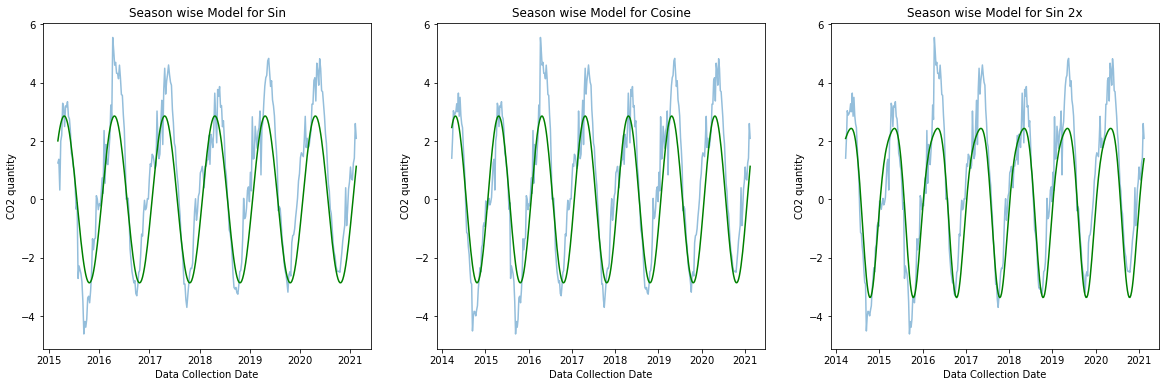

In [ ]:
#data["quantity"] = R_quadratic

plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["quantity"]], alpha=0.48)
plt.plot(data.loc[2900:, ["Date"]], calculate_sine[2900:], color="green")
plt.title("Season wise Model for Sin")
plt.xlabel("Data Collection Date")
plt.ylabel('CO2 quantity')

plt.subplot(1, 3, 2)
plt.plot(data.loc[2850:, ["Date"]], data.loc[2850:, ["quantity"]], alpha=0.48)
plt.plot(data.loc[2850:, ["Date"]], calculate_cosine[2850:], color="green")
plt.title("Season wise Model for Cosine")
plt.xlabel("Data Collection Date")
plt.ylabel('CO2 quantity')

plt.subplot(1, 3, 3)
plt.plot(data.loc[2850:, ["Date"]], data.loc[2850:, ["quantity"]], alpha=0.48)
plt.plot(data.loc[2850:, ["Date"]], calculate_sin_minus_2x[2850:], color="green")
plt.title("Season wise Model for Sin 2x")
plt.xlabel("Data Collection Date")
plt.ylabel('CO2 quantity')
plt.show()

In [ ]:
#calculating the residuals from each model
R_sin = data.quantity - calculate_sine
R_cosine = data.quantity - calculate_cosine
R_sin_2x = data.quantity - calculate_sin_minus_2x

# calculating the root mean square error and comparing
sin_compare = np.sqrt(np.mean(R_sin**2))
cosine_compare = np.sqrt(np.mean(R_cosine**2))
sin_2x_compare = np.sqrt(np.mean(R_sin_2x**2))

print(f'The RMSE of sin is {sin_compare}')
print(f'The RMSE of cosine is {cosine_compare}')
print(f'The RMSE of Sine 2x is {sin_2x_compare}')

The RMSE of sin is 0.9823530485987045
The RMSE of cosine is 0.9823538029503928
The RMSE of Sine 2x is 0.9130991302181246


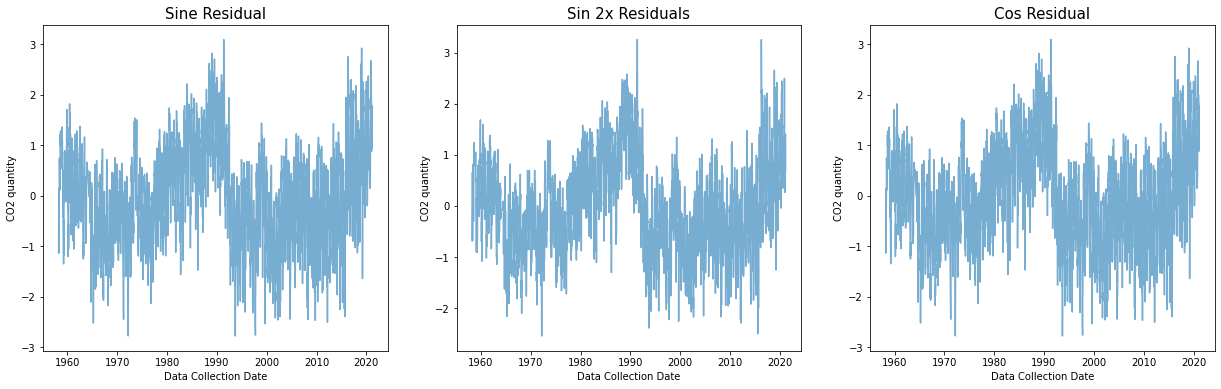

In [ ]:
plt.figure(figsize=(21,6))
plt.subplot(1, 3, 1)
plt.plot(data.Date, R_sin, alpha = 0.6)
plt.title("Sine Residual", size=15)
plt.xlabel("Data Collection Date")
plt.ylabel('CO2 quantity')

plt.subplot(1, 3, 3)
plt.plot(data.Date, R_cosine, alpha = 0.6)
plt.title("Cos Residual", size=15)
plt.xlabel("Data Collection Date")
plt.ylabel('CO2 quantity')

plt.subplot(1, 3, 2)
plt.plot(data.Date, R_sin_2x, alpha = 0.6)
plt.title("Sin 2x Residuals", size=15)
plt.xlabel("Data Collection Date")
plt.ylabel('CO2 quantity')
plt.show()

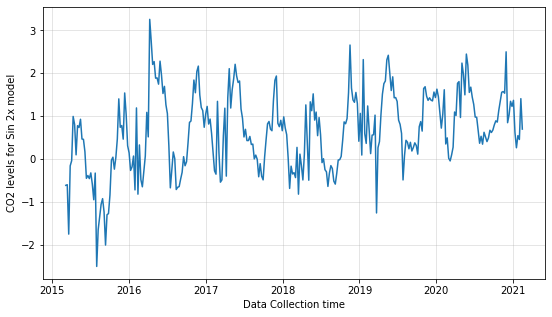

In [ ]:
# using sin 2x model to show the the CO2 increase

data["irregularity_sts_ppm"] = R_sin_2x

plt.figure(figsize=(9,5))
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["irregularity_sts_ppm"]])
plt.grid(alpha=0.4)
plt.xlabel("Data Collection time")
plt.ylabel('CO2 levels for Sin 2x model')
plt.show()

In [ ]:
# Determining coefficients from our datapoints and taking posteriors
initial_datapoints = np.array(list(map(list, zip(*dps_quadratic.values()))))[:1950, :3]

season_wise_datapoints = list(map(list, zip(*dps_sin_minus_2x.values())))

# There was a vector containing phase, which we overlook
season_wise_datapoints = np.array([datapoint[:2] + datapoint[3:5] for datapoint in season_wise_datapoints])

In [ ]:
# now we shall create the func_likelihood for the model
def func_likelihood(year_clock, dp_trend, dp_season_wise):
    a0, a1, a2 = dp_trend
    a3, a4, irregularity_sts, phase = dp_season_wise

    return(np.array(sts.norm.rvs(a0 + a1*year_clock + a2*year_clock**2 + \
                                 a3*np.sin(2*np.pi*year_clock + phase) + \
                                 a4*np.sin(4*np.pi*year_clock + phase), irregularity_sts))) 

### Inference

In [ ]:
# Dates for which we want to forecast atmosphere using time series
forecast_date = pd.date_range("2021-05-04", "2060-05-04", freq='W-THU')
forecast_time = (forecast_date - pd.to_datetime(data.Date[0])).days / 365.25

# Generate predictions
forecast_atmos = np.array([func_likelihood(forecast_time, dp_trend, dp_season_wise) \
                   for dp_trend, dp_season_wise in zip(initial_datapoints, season_wise_datapoints)])

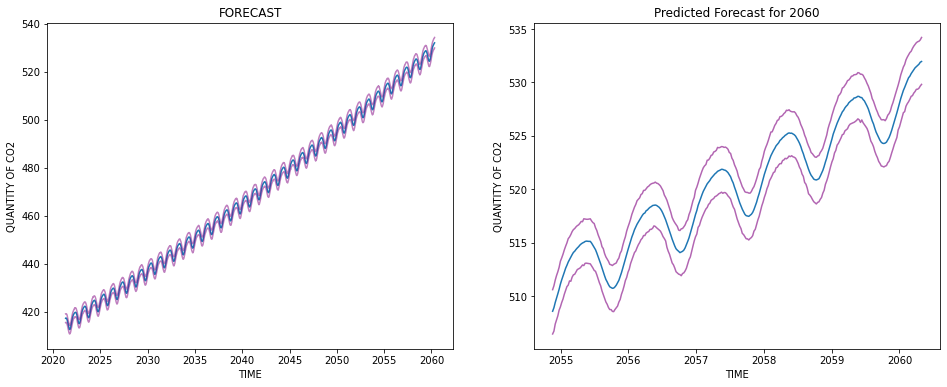

In [ ]:
# Mean and CI of the predictions
forecast_average = forecast_atmos.mean(axis=0)
lower_bound = np.percentile(forecast_atmos, axis=0, q=2.5)
upper_bound = np.percentile(forecast_atmos, axis=0, q=97.5)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("FORECAST")
plt.xlabel("TIME")
plt.ylabel('QUANTITY OF CO2')
plt.plot(forecast_date, forecast_average)
plt.plot(forecast_date, lower_bound, color="purple", alpha=0.6)
plt.plot(forecast_date, upper_bound, color="purple", alpha=0.6)

plt.subplot(1,2,2)
plt.title("Predicted Forecast for 2060")
plt.xlabel("TIME")
plt.ylabel('QUANTITY OF CO2')
plt.plot(forecast_date[1750:], forecast_average[1750:])
plt.plot(forecast_date[1750:], lower_bound[1750:], color="purple", alpha=0.6)
plt.plot(forecast_date[1750:], upper_bound[1750:], color="purple", alpha=0.6)
plt.show()

In [ ]:
forecast_datapoints = pd.DataFrame({"Date":forecast_date, 
                          "2.5%":lower_bound, 
                          "Mean":forecast_average, 
                          "97.5":upper_bound})

In [ ]:
print('Predicted Forecast carbon dioxide level at the time of {:{dfmt}} will be {:.0f} parts per million.'.format(
    forecast_datapoints.iloc[-1,0],forecast_datapoints.iloc[-1,2], dfmt='%Y-%m-%d'))

print('Prediction of 95 percent confidence interval will be [{:.1f}, {:.1f}].'.format(
    forecast_datapoints.iloc[-1,1],forecast_datapoints.iloc[-1,3]))

Predicted Forecast carbon dioxide level at the time of 2060-04-29 will be 532 parts per million.
Prediction of 95 percent confidence interval will be [529.8, 534.2].


In [ ]:
print("{:{dfmt}} will be the day when CO2 level will exceed 450 ppm.".format(
    forecast_date[np.min(np.argwhere(lower_bound > 450))], dfmt='%Y-%m-%d'))
# 8th February of 2035 will be when we cross the 450 ppm level

2035-02-08 will be the day when CO2 level will exceed 450 ppm.


### Predictive Check for Forecast

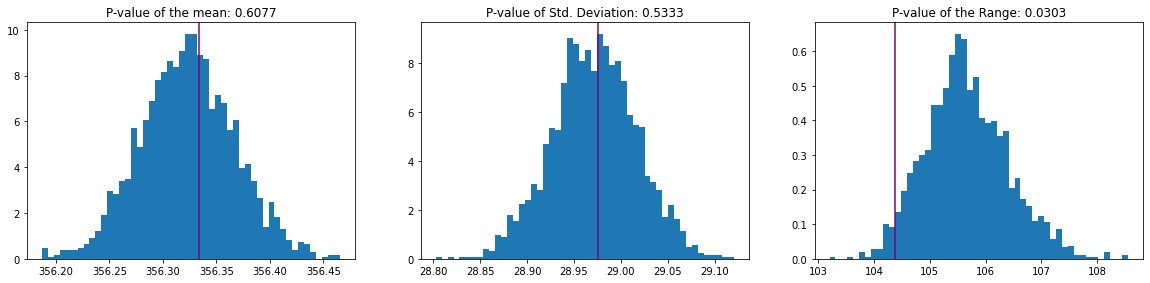

In [ ]:
# Predictive Check for Forecast
forecast_dp = np.array([func_likelihood(data.Years.values, dp_trend, dp_season_wise) \
                   for dp_trend, dp_season_wise in zip(initial_datapoints, season_wise_datapoints)])

plt.figure(figsize=(20,20))
# The test statistic for the generated data.
test_stat = np.mean(forecast_dp, axis=1)
expected_value = np.mean(data.ppm.values)
plt.subplot(4, 3, 1)
plt.hist(test_stat, bins=50, density=True)
plt.title('P-value of the mean: {:.4f}'.format(np.mean(test_stat < expected_value)))
plt.axvline(expected_value, color='purple')
#MEAN

# STD DEVIATION
test_stat1 = np.std(forecast_dp, axis=1)
expected_value1 = np.std(data.ppm.values)
plt.subplot(4, 3, 2)
plt.hist(test_stat1, bins=50, density=True)
plt.title('P-value of Std. Deviation: {:.4f}'.format(np.mean(test_stat1 < expected_value1)))
plt.axvline(expected_value1, color='purple')

# RANGE OF THE DATA
test_stat2 = np.ptp(forecast_dp, axis=1)
expected_value2 = np.ptp(data.ppm.values)
plt.subplot(4, 3, 3)
plt.hist(test_stat2, bins=50, density=True)
plt.title('P-value of the Range: {:.4f}'.format(np.mean(test_stat2 < expected_value2)))
plt.axvline(expected_value2, color='purple')
plt.show()